In [252]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.calibration import calibration_curve
from os.path import join
from glob import glob

In [21]:
data_path = "/d1/dgagne/ci_hackathon_2017/"
lme_file_template = "b.e11.BLMTRC5CN.f19_g16.{0:03d}.cam.h0.{1:s}.085012-200412.nc"
precip_file_template = "DJF_precip_lme_cam_{0:03d}_PRECT_0851-2005.csv"
precip_data = []
for ens in range(2, 14):
    precip_data.append(pd.read_csv(join(data_path, precip_file_template.format(ens)), 
                                   names=["Year", "Precip_{0:02d}".format(ens)], index_col="Year"))
all_precip_data = pd.concat(precip_data,axis=1)

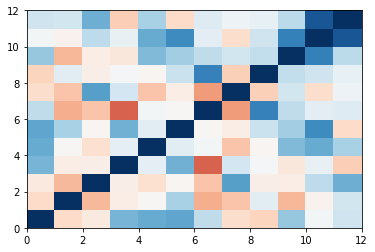

In [20]:
plt.pcolormesh(np.corrcoef(all_precip_data.values.T), vmin=-0.1, vmax=0.1, cmap="RdBu")

In [22]:
data_vars = ["PSL", "TS", "TMQ"]
train_data = {}
test_data = {}
train_members = [2, 4, 6]
test_members = [3, 5, 7]
for var in data_vars:
    print(var)
    train_data[var] = {}
    test_data[var] = {}
    for mem in train_members:
        print(mem)
        ds = xr.open_dataset(join(data_path, lme_file_template.format(mem, var)))
        ds.load()
        train_data[var][mem] = ds[var]
        ds.close()
    for mem in test_members:
        print(mem)
        ds = xr.open_dataset(join(data_path, lme_file_template.format(mem, var)))
        ds.load()
        test_data[var][mem] = ds[var]
        ds.close()

PSL
2


/Users/dgagne/anaconda3/lib/python3.5/site-packages/xarray/conventions.py:377: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/Users/dgagne/anaconda3/lib/python3.5/site-packages/xarray/conventions.py:396: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  calendar=self.calendar)


4
6
3
5
7
TS
2
4
6
3
5
7
TMQ
2
4
6
3
5
7


In [58]:
train_data_stats = {}
test_data_stats = {}
for var in data_vars:
    train_data_stats[var] = {}
    test_data_stats[var] = {}
    for mem in train_members:
        train_data_stats[var][mem] = {}
        train_data_stats[var][mem]["mean"] = train_data[var][mem].mean(axis=0)
        train_data_stats[var][mem]["sd"] = train_data[var][mem].std(axis=0)
    for mem in test_members:
        test_data_stats[var][mem] = {}
        test_data_stats[var][mem]["mean"] = test_data[var][mem].mean(axis=0)
        test_data_stats[var][mem]["sd"] = test_data[var][mem].std(axis=0)

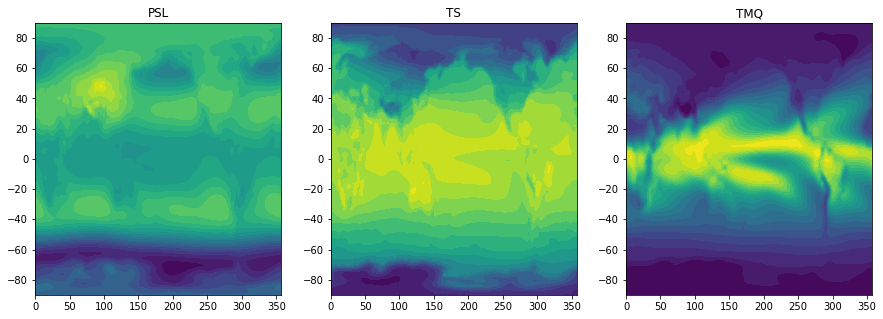

In [162]:
fig, axes = plt.subplots(1, len(train_members), figsize=(15, 5))
for v, var in enumerate(data_vars):
    axes[v].contourf(train_data_stats[var][2]["mean"]["lon"], 
                     train_data_stats[var][2]["mean"]["lat"], 
                     train_data_stats[var][2]["mean"], 20)
    axes[v].set_title(var)

In [156]:
train_data_stats["TS"][mem]["mean"]

<xarray.DataArray 'TS' (lat: 96, lon: 144)>
array([[ 229.25024414,  229.72348022,  229.24275208, ...,  229.70765686,
         229.21315002,  229.23800659],
       [ 229.62275696,  229.44044495,  229.21238708, ...,  230.10722351,
         229.49082947,  229.76676941],
       [ 229.67245483,  229.68357849,  229.52261353, ...,  230.14263916,
         230.0043335 ,  229.75189209],
       ..., 
       [ 240.09669495,  240.22634888,  240.33450317, ...,  239.63452148,
         239.77868652,  239.93411255],
       [ 239.45509338,  239.49815369,  239.52537537, ...,  239.24409485,
         239.3170929 ,  239.38818359],
       [ 238.77046204,  238.76042175,  238.75238037, ...,  238.76417542,
         238.77200317,  238.77606201]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 -82.42 -80.53 -78.63 ...
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 12.5 15.0 17.5 20.0 22.5 ...

In [60]:
train_data_anomalies = {}
test_data_anomalies = {}
for var in data_vars:
    train_data_anomalies[var] = {}
    test_data_anomalies[var] = {}
    for mem in train_members:
        train_data_anomalies[var][mem] = (train_data[var][mem] - train_data_stats[var][mem]["mean"]) / (train_data_stats[var][mem]["sd"])
    for mem in test_members:
        test_data_anomalies[var][mem] = (test_data[var][mem] - test_data_stats[var][mem]["mean"]) / (test_data_stats[var][mem]["sd"])

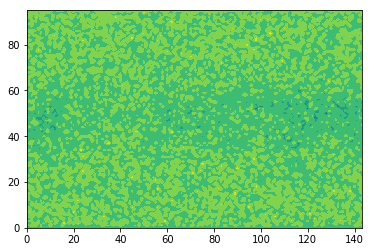

In [175]:
plt.contourf(train_data_anomalies["PSL"][2].std(axis=0))

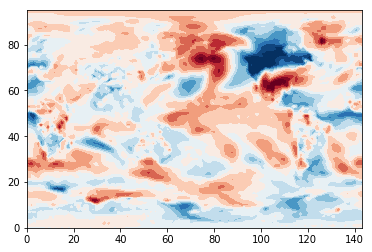

In [37]:
plt.contourf(train_data_anomalies["TS"][2][25], 20, vmin=-3, vmax=3, cmap="RdBu_r")

In [39]:
train_data_pca = {}
for var in data_vars:
    train_data_pca[var] = {}
    for mem in train_members:
        train_data_pca[var][mem] = PCA(n_components=20)
        train_data_pca[var][mem].fit(train_data_anomalies[var][mem].values.reshape(-1, np.prod(train_data_anomalies[var][mem].shape[1:])))

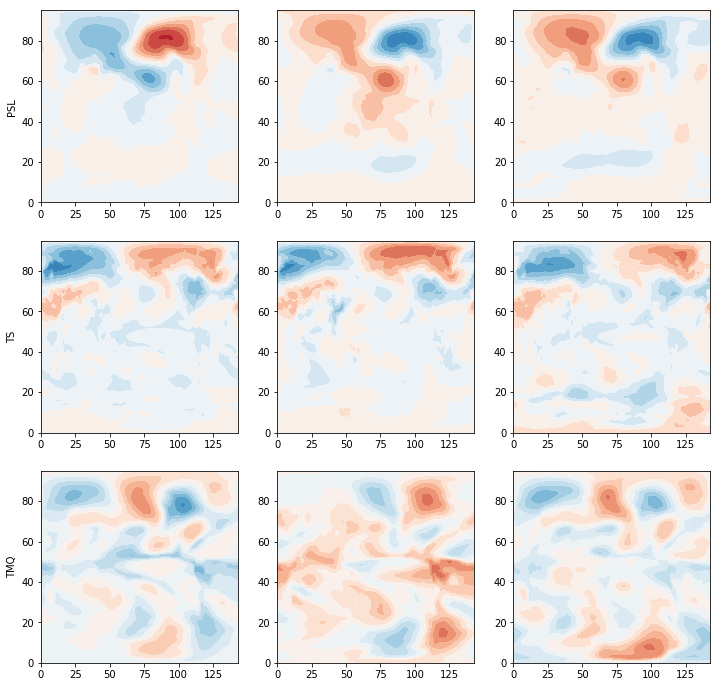

In [50]:
fig, axes = plt.subplots(len(data_vars), len(train_members), figsize=(12, 12))
for v, var in enumerate(data_vars):
    axes[v, 0].set_ylabel(var)
    for m, mem in enumerate(train_members):
       axes[v, m].contourf(train_data_pca[var][mem].components_[5].reshape(train_data_anomalies[var][mem].shape[1:]), 
                           10, vmin=-0.05, vmax=0.05, cmap="RdBu_r") 

In [61]:
train_data_pca_trans = np.zeros((np.sum([x.shape[0] for x in train_data_anomalies[var].values()]), 60))
test_data_pca_trans = np.zeros((np.sum([x.shape[0] for x in test_data_anomalies[var].values()]), 60))
r_i = 0
for m, mem in enumerate(train_members):
    v_i = 0
    for v, var in enumerate(data_vars):
        train_data_pca_trans[r_i:r_i+train_data_anomalies[var][mem].shape[0], v_i: v_i + 20] = \
            train_data_pca[var][2].transform(train_data_anomalies[var][mem].values.reshape(-1, 
                np.prod(train_data_anomalies[var][mem].shape[1:])))
        v_i += 20
    r_i += train_data_anomalies[var][mem].shape[0]
r_i = 0
for m, mem in enumerate(test_members):
    v_i = 0
    for v, var in enumerate(data_vars):
        test_data_pca_trans[r_i:r_i+test_data_anomalies[var][mem].shape[0], v_i: v_i + 20] = \
            train_data_pca[var][2].transform(test_data_anomalies[var][mem].values.reshape(-1, 
                np.prod(test_data_anomalies[var][mem].shape[1:])))
        v_i += 20
    r_i += test_data_anomalies[var][mem].shape[0]


In [184]:
lr = LogisticRegression(penalty="l1", C=0.001)
train_precip = np.concatenate([all_precip_data["Precip_{0:02d}".format(m)].values for m in train_members])
train_labels = np.where(train_precip >= train_precip.mean(), 1, 0)
lr.fit(train_data_pca_trans, train_labels)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [185]:
test_precip = np.concatenate([all_precip_data["Precip_{0:02d}".format(m)].values for m in test_members])
test_labels = np.where(test_precip >= test_precip.mean(), 1, 0)

In [186]:
lr_preds = lr.predict_proba(test_data_pca_trans)[:, 1]

In [219]:
np.mean((lr_preds - test_labels) ** 2)

0.21725675137226758

In [218]:
np.mean((test_labels.mean() - test_labels) ** 2)

0.24806298399371995

In [188]:
np.argsort(np.abs(lr.coef_)[0])[::-1]

array([20,  1,  2, 54, 53, 52, 42, 19,  5, 24, 21,  4,  0, 29, 22, 51, 11,
       49, 50, 18, 17, 16, 15, 14, 13, 12, 10, 44,  9,  8,  7,  6, 55,  3,
       56, 57, 48, 45, 23, 47, 43, 46, 41, 40, 39, 38, 37, 36, 35, 34, 33,
       32, 31, 30, 58, 28, 27, 26, 25, 59])

In [123]:
gbr = GradientBoostingClassifier(learning_rate=0.01, verbose=2, n_estimators=500, max_depth=6, max_features="sqrt", subsample=0.9)
gbr.fit(train_data_pca_trans, train_labels)
gbr_preds = gbr.predict_proba(test_data_pca_trans)[:, 1]

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3657           0.0026            3.72s
         2           1.3632           0.0020            3.83s
         3           1.3541           0.0017            4.01s
         4           1.3522           0.0027            3.95s
         5           1.3480           0.0020            3.94s
         6           1.3423           0.0029            3.90s
         7           1.3392           0.0022            3.86s
         8           1.3373           0.0014            3.96s
         9           1.3324           0.0022            3.92s
        10           1.3308           0.0024            3.89s
        11           1.3255           0.0018            3.88s
        12           1.3215           0.0030            3.88s
        13           1.3177           0.0022            3.87s
        14           1.3138           0.0022            3.83s
        15           1.3109           0.0020            3.79s
       

       154           1.0167           0.0004            2.76s
       155           1.0098          -0.0001            2.75s
       156           1.0120           0.0002            2.75s
       157           1.0124           0.0002            2.74s
       158           1.0082          -0.0001            2.73s
       159           1.0051          -0.0002            2.72s
       160           1.0115           0.0004            2.72s
       161           1.0092           0.0000            2.71s
       162           1.0061           0.0002            2.70s
       163           1.0008          -0.0003            2.69s
       164           1.0022           0.0002            2.69s
       165           1.0033          -0.0004            2.68s
       166           1.0035           0.0001            2.67s
       167           0.9975          -0.0001            2.66s
       168           0.9973           0.0000            2.65s
       169           0.9965           0.0001            2.65s
       1

       309           0.8429          -0.0002            1.52s
       310           0.8479          -0.0003            1.51s
       311           0.8463          -0.0002            1.50s
       312           0.8415          -0.0001            1.49s
       313           0.8412           0.0001            1.49s
       314           0.8460          -0.0002            1.48s
       315           0.8351          -0.0000            1.47s
       316           0.8387          -0.0000            1.46s
       317           0.8366          -0.0001            1.45s
       318           0.8447           0.0000            1.44s
       319           0.8416           0.0002            1.44s
       320           0.8382          -0.0003            1.43s
       321           0.8365           0.0000            1.42s
       322           0.8398          -0.0003            1.41s
       323           0.8335          -0.0005            1.41s
       324           0.8355           0.0001            1.40s
       3

       444           0.7500           0.0000            0.44s
       445           0.7529           0.0000            0.43s
       446           0.7525          -0.0003            0.42s
       447           0.7486          -0.0002            0.42s
       448           0.7500          -0.0002            0.41s
       449           0.7442          -0.0003            0.40s
       450           0.7480          -0.0003            0.39s
       451           0.7473          -0.0002            0.38s
       452           0.7494          -0.0002            0.38s
       453           0.7479          -0.0001            0.37s
       454           0.7457          -0.0000            0.36s
       455           0.7469           0.0002            0.35s
       456           0.7456           0.0000            0.34s
       457           0.7428          -0.0002            0.34s
       458           0.7416          -0.0000            0.33s
       459           0.7476          -0.0001            0.32s
       4

In [217]:
np.mean((gbr_preds - test_labels) ** 2)

0.21501371633035235

In [137]:
gbr_prob_true, gbr_bin = calibration_curve(test_labels, gbr_preds, n_bins=10)
lr_prob_true, lr_bin = calibration_curve(test_labels, lr_preds, n_bins=10)

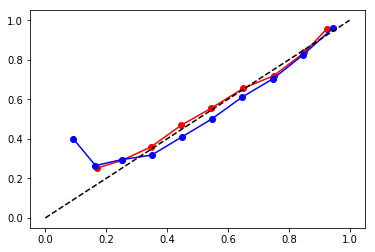

In [138]:
plt.plot(gbr_bin, gbr_prob_true, 'ro-')
plt.plot(lr_bin, lr_prob_true, 'bo-')

plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1,0.1), 'k--')

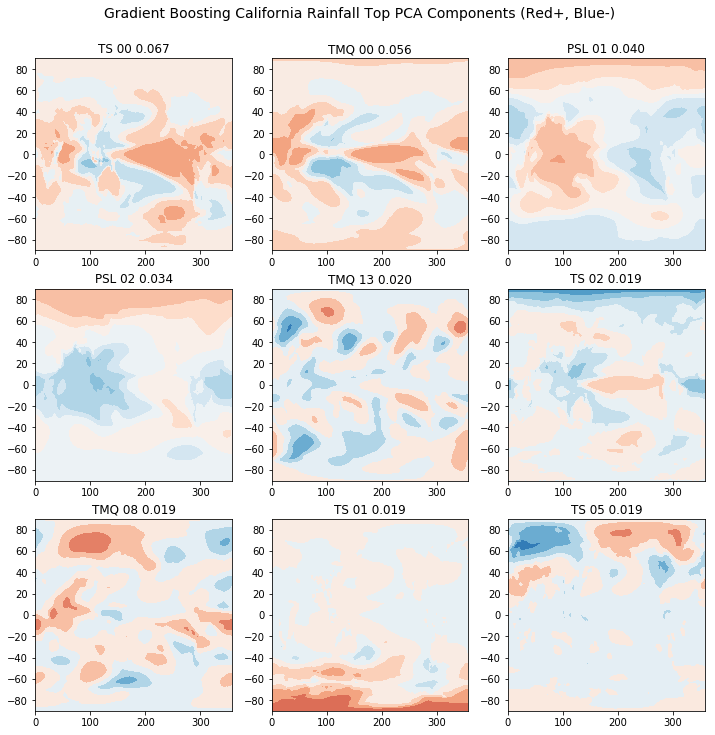

In [199]:
feature_rankings = gbr.feature_importances_.argsort()[::-1]
fig, axes = plt.subplots(3,3, figsize=(12, 12))
axef = axes.ravel()
a = 0
for fr in feature_rankings[:9]:
    fr_var = data_vars[int(np.floor(fr / 20))]
    fr_comp = fr % 20
    axef[a].contourf(train_data[fr_var][2]["lon"], 
                     train_data[fr_var][2]["lat"], 
                     train_data_pca[fr_var][2].components_[fr_comp].reshape(train_data_anomalies[fr_var][2].shape[1:]),
                     5,
                     vmin=-0.05,
                     vmax=0.05,
                     cmap="RdBu_r"
                    )
    axef[a].set_title(fr_var + " {0:02d} {1:0.3f}".format(fr_comp, gbr.feature_importances_[fr]))
    a += 1
fig.suptitle("Gradient Boosting California Rainfall Top PCA Components (Red+, Blue-)", fontsize=14, y=0.94)

[20  1  2 54 53 52 42 19  5 24 21  4  0 29 22 51 11 49 50 18 17 16 15 14 13
 12 10 44  9  8  7  6 55  3 56 57 48 45 23 47 43 46 41 40 39 38 37 36 35 34
 33 32 31 30 58 28 27 26 25 59]
[  1.07819850e-02   8.22736162e-03  -7.71907811e-03   4.93541658e-03
   2.93557789e-03   2.91244821e-03  -2.41336687e-03  -1.99665964e-03
   1.78498226e-03   1.76641965e-03  -1.34836830e-03  -1.16564286e-03
   1.14784282e-03   8.08113461e-04   7.45651754e-04  -4.24729527e-05
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.0

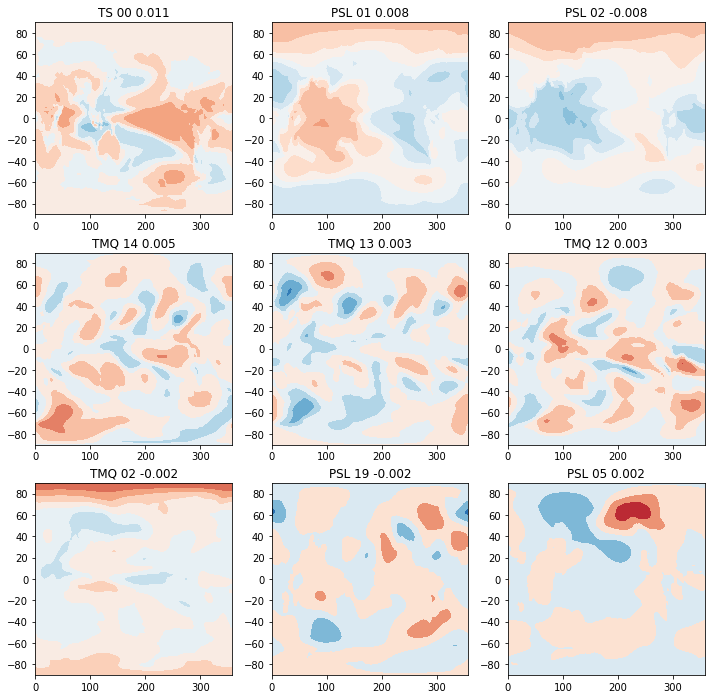

In [189]:
feature_rankings = np.abs(lr.coef_[0]).argsort()[::-1]
print(feature_rankings)
print(lr.coef_[0][feature_rankings])
fig, axes = plt.subplots(3,3, figsize=(12, 12))
axef = axes.ravel()
a = 0
for fr in feature_rankings[:9]:
    fr_var = data_vars[int(np.floor(fr / 20))]
    fr_comp = fr % 20
    axef[a].contourf(train_data[fr_var][2]["lon"], 
                     train_data[fr_var][2]["lat"], 
                     train_data_pca[fr_var][2].components_[fr_comp].reshape(train_data_anomalies[fr_var][2].shape[1:]),
                     5,
                     vmin=-0.05,
                     vmax=0.05,
                     cmap="RdBu_r"
                    )
    axef[a].set_title(fr_var + " {0:02d} {1:0.3f}".format(fr_comp, lr.coef_[0][fr]))
    a += 1

In [146]:
feature_rankings % 20

array([ 0,  0,  1,  2, 13,  2,  8,  1,  5, 13, 19, 14,  2, 12, 12,  6,  5,
        9, 16,  4, 13,  3,  7, 19, 18,  4, 17, 16,  7,  6,  5,  9, 11,  4,
       18, 17,  8, 11,  0,  6, 18,  8, 10, 19, 15, 17, 15, 12, 14,  7, 10,
       14, 10,  3,  9,  3, 15, 11,  1, 16])

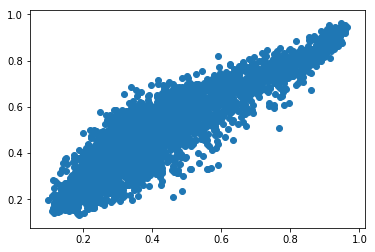

In [195]:
plt.scatter(gbr_preds, lr_preds)

In [248]:
las = Lasso(alpha=1)
las.fit(train_data_pca_trans, np.sqrt(train_precip))

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [249]:
lasso_preds = las.predict(test_data_pca_trans) ** 2

In [246]:
lasso_preds

array([ 502.47509074,  502.40207928,  475.97619347, ...,  518.35267155,
        469.66836146,  441.46182898])

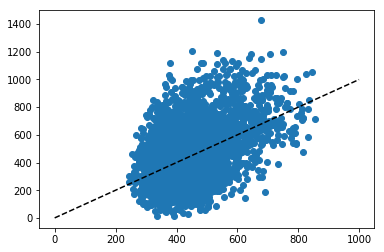

In [250]:
plt.scatter(lasso_preds, test_precip)
plt.plot(np.arange(1000), np.arange(1000), 'k--')

In [251]:
np.corrcoef(lasso_preds, test_precip)

array([[ 1.        ,  0.45719652],
       [ 0.45719652,  1.        ]])

In [262]:
print(np.sqrt(np.mean((lasso_preds - test_precip) ** 2)))
print(np.mean((lasso_preds - test_precip)))

187.440812271
-11.1952062392


(array([   6.,   45.,  220.,  589.,  839.,  872.,  577.,  237.,   74.,    6.]),
 array([  3.31385704,   6.76014461,  10.20643218,  13.65271975,
         17.09900732,  20.54529489,  23.99158247,  27.43787004,
         30.88415761,  34.33044518,  37.77673275]),
 <a list of 10 Patch objects>)

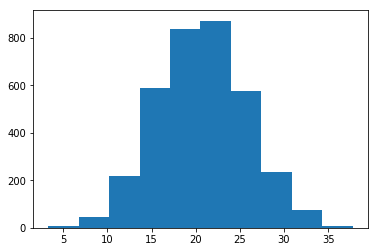

In [223]:
plt.hist(np.sqrt(test_precip))

In [253]:
gb_rain = GradientBoostingRegressor(loss="ls", learning_rate=0.05, max_depth=5, 
                                    n_estimators=500, max_features="sqrt", verbose=2)
gb_rain.fit(train_data_pca_trans, np.sqrt(train_precip))

      Iter       Train Loss   Remaining Time 
         1          25.1365            2.25s
         2          24.5878            2.39s
         3          24.1082            2.38s
         4          23.7570            2.42s
         5          23.4197            2.43s
         6          22.9732            2.44s
         7          22.6013            2.41s
         8          22.3031            2.38s
         9          22.0485            2.35s
        10          21.7047            2.34s
        11          21.4023            2.34s
        12          21.0663            2.33s
        13          20.9540            2.31s
        14          20.6954            2.31s
        15          20.4906            2.30s
        16          20.2272            2.32s
        17          20.0618            2.31s
        18          19.8540            2.31s
        19          19.6320            2.29s
        20          19.4739            2.27s
        21          19.4033            2.25s
        2

       191           9.8705            1.31s
       192           9.8198            1.31s
       193           9.7935            1.31s
       194           9.7594            1.30s
       195           9.7357            1.30s
       196           9.7069            1.29s
       197           9.6856            1.29s
       198           9.6439            1.29s
       199           9.6226            1.28s
       200           9.5968            1.28s
       201           9.5770            1.27s
       202           9.5575            1.27s
       203           9.5474            1.26s
       204           9.5381            1.26s
       205           9.5244            1.25s
       206           9.4972            1.25s
       207           9.4745            1.25s
       208           9.4393            1.24s
       209           9.3980            1.24s
       210           9.3831            1.23s
       211           9.3549            1.23s
       212           9.3211            1.23s
       213

       382           5.8738            0.50s
       383           5.8674            0.50s
       384           5.8498            0.49s
       385           5.8413            0.49s
       386           5.8297            0.48s
       387           5.8074            0.48s
       388           5.7893            0.48s
       389           5.7678            0.47s
       390           5.7431            0.47s
       391           5.7330            0.46s
       392           5.7169            0.46s
       393           5.7065            0.46s
       394           5.6900            0.45s
       395           5.6793            0.45s
       396           5.6526            0.44s
       397           5.6430            0.44s
       398           5.6297            0.43s
       399           5.6095            0.43s
       400           5.6009            0.43s
       401           5.5880            0.42s
       402           5.5733            0.42s
       403           5.5586            0.41s
       404

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=5,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=None,
             subsample=1.0, verbose=2, warm_start=False)

In [254]:
gb_rain_preds = gb_rain.predict(test_data_pca_trans) ** 2

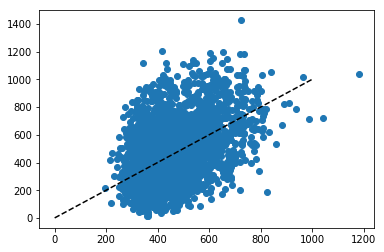

In [256]:
plt.scatter(gb_rain_preds, test_precip)
plt.plot(np.arange(1000), np.arange(1000), 'k--')

In [257]:
np.corrcoef(gb_rain_preds, test_precip)

array([[ 1.        ,  0.42906556],
       [ 0.42906556,  1.        ]])

In [261]:
print(np.sqrt(np.mean((gb_rain_preds - test_precip) ** 2)))
print(np.mean((gb_rain_preds - test_precip)))

191.651266509
-11.0073440504
